# Transferability Analysis: Sparse GT vs GCN

This notebook fetches runs from wandb and creates transferability plots comparing Sparse GT and GCN performance across different training densities (resolutions).


In [1]:
import wandb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Initialize wandb API
api = wandb.Api()


## Fetch Runs from Wandb


In [5]:
ENTITY = 'alelab'
PROJECT = 'terrains'
TAG = 'e20TG_neurogf_terrain_graphs'

def fetch_runs(entity: str, project: str, tag: str) -> pd.DataFrame:
    """
    Fetch runs from a wandb project filtered by tag.
    
    Args:
        entity: wandb entity (user or team)
        project: wandb project name
        tag: wandb tag to filter runs
    
    Returns:
        DataFrame with run information
    """
    # Fetch running and finished runs with the specified tag
    filters = {
        "$and": [
            {"$or": [{"state": "running"}, {"state": "finished"}]},
            {"tags": tag}
        ]
    }
    runs = api.runs(f"{entity}/{project}", filters=filters)
    
    records = []
    for run in runs:
        # Get summary metrics
        summary = run.summary._json_dict
        config = run.config
        
        # Get normalized_abs_error (might be named normalized_abs_err in some runs)
        normalized_abs_error = summary.get('normalized_abs_error') or summary.get('normalized_abs_err', 0)
        
        # Skip runs with zero/missing normalized_abs_error
        if not normalized_abs_error or normalized_abs_error == 0:
            continue
        
        # Extract resolution from dataset_name or train_data
        dataset_name = config.get('dataset_name', '')
        train_data = config.get('train_data', '')
        
        # Try to extract resolution number (e.g., res17 -> 17)
        res_match = re.search(r'res(\d+)', dataset_name) or re.search(r'res(\d+)', train_data)
        if res_match:
            resolution = int(res_match.group(1))
        else:
            # Skip runs without resolution info
            continue
        
        records.append({
            'run_id': run.id,
            'run_name': run.name,
            'state': run.state,
            'resolution': resolution,
            'train_density': resolution,  # Higher res number = sparser graph
            'normalized_abs_error': normalized_abs_error,
            'layer_type': config.get('layer_type', 'Unknown'),
            'epochs': config.get('epochs', 0),
            'learning_rate': config.get('learning_rate', 0),
            'dataset_name': dataset_name,
        })
    
    return pd.DataFrame(records)


print(f"Fetching runs from {ENTITY}/{PROJECT} with tag '{TAG}'...")
df = fetch_runs(ENTITY, PROJECT, TAG)
print(f"Found {len(df)} valid runs")
print(f"\nLayer types found: {df['layer_type'].unique().tolist() if len(df) > 0 else 'None'}")


Fetching runs from alelab/terrains with tag 'e20TG_neurogf_terrain_graphs'...
Found 63 valid runs

Layer types found: ['TAGConv', 'SparseGT']


In [ ]:
# Add density column (inverse of resolution squared - represents actual node density in 2D grid)
df['density'] = 1 / (df['resolution'] ** 2)

# Use layer_type as model_type for consistency with downstream code
df['model_type'] = df['layer_type']

print(f"Total runs: {len(df)}")
print(f"\nRuns by model type (layer_type):")
print(df['model_type'].value_counts())
print(f"\nDensities available (1/resolution²):")
print(sorted(df['density'].unique(), reverse=True))


Total runs: 290

Runs by model type:
model_type
Sparse GT    145
GCN          145
Name: count, dtype: int64

Densities available (1/resolution²):
[np.float64(1.0), np.float64(0.25), np.float64(0.1111111111111111), np.float64(0.0625), np.float64(0.04), np.float64(0.027777777777777776), np.float64(0.02040816326530612), np.float64(0.015625), np.float64(0.012345679012345678), np.float64(0.01), np.float64(0.008264462809917356), np.float64(0.006944444444444444), np.float64(0.005917159763313609), np.float64(0.00510204081632653), np.float64(0.0044444444444444444), np.float64(0.00390625), np.float64(0.0034602076124567475), np.float64(0.0030864197530864196), np.float64(0.002770083102493075), np.float64(0.0025), np.float64(0.0022675736961451248), np.float64(0.002066115702479339), np.float64(0.001890359168241966), np.float64(0.001736111111111111), np.float64(0.0016), np.float64(0.0014792899408284023), np.float64(0.0013717421124828531), np.float64(0.0012755102040816326), np.float64(0.00118906064209

In [25]:
# Debug: Inspect the dataframe to verify both model types have data
print("DataFrame shape:", df.shape)
print("\nRuns per model_type:")
print(df['model_type'].value_counts())
print("\nLayer types in the data:")
print(df.groupby('model_type')['layer_type'].value_counts())
print("\nSample of each model type:")
print("\n--- Sparse GT samples ---")
print(df[df['model_type'] == 'Sparse GT'][['run_name', 'density', 'normalized_abs_error', 'layer_type']].head())
print("\n--- GCN samples ---")
print(df[df['model_type'] == 'GCN'][['run_name', 'density', 'normalized_abs_error', 'layer_type']].head())


DataFrame shape: (290, 12)

Runs per model_type:
model_type
Sparse GT    145
GCN          145
Name: count, dtype: int64

Layer types in the data:
model_type  layer_type
GCN         TAGConv       76
            SparseGT      67
            MLP            2
Sparse GT   TAGConv       76
            SparseGT      67
            MLP            2
Name: count, dtype: int64

Sample of each model type:

--- Sparse GT samples ---
                       run_name  density  normalized_abs_error layer_type
0      terrain-graph-mlp-stage1  1.00000              0.005761        MLP
1      terrain-graph-mlp-stage2  1.00000              0.007844        MLP
2  terrain-graph-TAGConv-stage1  0.00250              0.018958    TAGConv
3  terrain-graph-TAGConv-stage1  0.00277              0.017410    TAGConv
4  terrain-graph-TAGConv-stage2  0.00250              0.004849    TAGConv

--- GCN samples ---
                         run_name  density  normalized_abs_error layer_type
145      terrain-graph-mlp-stage1  

In [26]:
# Extract stage from dataset_name
# Rules:
# - If layer_type == 'SparseGT': 
#     - "norway/res##" = stage 1
#     - "res##_phase2" = stage 2
# - If layer_type != 'SparseGT':
#     - "norway/res##" = stage 1  
#     - "res##_phase{num}" = stage num

def extract_stage(row):
    layer_type = row['layer_type']
    dataset_name = row['dataset_name']
    
    if layer_type == 'SparseGT':
        # For SparseGT: norway/res## = stage 1, res##_phase2 = stage 2
        if 'norway/' in dataset_name:
            return 1
        elif '_phase2' in dataset_name:
            return 2
        else:
            return None
    else:
        # For other layer types (TAGConv, etc.): extract phase number
        if 'norway/' in dataset_name:
            return 1
        match = re.search(r'_phase(\d+)', dataset_name)
        if match:
            return int(match.group(1))
        else:
            return None

df['stage'] = df.apply(extract_stage, axis=1)

# Display the result
print("Stage distribution:")
print(df.groupby(['model_type', 'layer_type', 'stage']).size())
print("\nSample data with stage:")
df[['model_type', 'layer_type', 'dataset_name', 'stage', 'density', 'normalized_abs_error']].sample(25)

Stage distribution:
model_type  layer_type  stage
GCN         MLP         1.0       1
            SparseGT    1.0      34
                        2.0      33
            TAGConv     1.0      37
                        2.0      39
Sparse GT   MLP         1.0       1
            SparseGT    1.0      34
                        2.0      33
            TAGConv     1.0      37
                        2.0      39
dtype: int64

Sample data with stage:


,model_type,layer_type,dataset_name,stage,density,normalized_abs_error
268,GCN,SparseGT,norway/res36,1.0,0.000772,0.017955
10,Sparse GT,TAGConv,norway/res16,1.0,0.003906,0.017705
146,GCN,MLP,generated/res01_phase1.npz,1.0,1.000000,0.007844
257,GCN,TAGConv,norway/res34,1.0,0.000865,0.019176
259,GCN,SparseGT,res32_phase2,2.0,0.000977,0.005235
96,Sparse GT,TAGConv,norway/res30,1.0,0.001111,0.019391
213,GCN,TAGConv,res24_phase2,2.0,0.001736,0.005528
131,Sparse GT,TAGConv,res38_phase2,2.0,0.000693,0.007673
15,Sparse GT,TAGConv,norway/res13,1.0,0.005917,0.018132
63,Sparse GT,TAGConv,res03_phase2,2.0,0.111111,0.008712


In [31]:
df[df.stage==2.0].groupby(['model_type','resolution'])['normalized_abs_error'].mean().reset_index().query('model_type=="Sparse GT"')

,model_type,resolution,normalized_abs_error
39,Sparse GT,2,0.016656
40,Sparse GT,3,0.008712
41,Sparse GT,4,0.047005
42,Sparse GT,5,0.006267
43,Sparse GT,6,0.004327
44,Sparse GT,7,0.004674
45,Sparse GT,8,0.003936
46,Sparse GT,9,0.004982
47,Sparse GT,10,0.005404
48,Sparse GT,11,0.004298


In [8]:
df[df.run_id=="58vwdzbe"]

,run_id,run_name,state,model_type,resolution,train_density,normalized_abs_error,layer_type,epochs,learning_rate,dataset_name,experiment_tag,density,stage
49,58vwdzbe,terrain-graph-SparseGT-res14_phase2-stage2,finished,GCN,14,14,0.006456,SparseGT,1000,0.001,res14_phase2,e21_sparse_gt_terrain_phase2,0.005102,2.0


In [20]:
## Compute Accuracy Proxy from Normalized Absolute Error

# Since we have the mean relative error (normalized_abs_error = NMAE),
# we can compute an "accuracy proxy" as 1 - error (capped at 0-100%)
# This is NOT the same as threshold-based accuracy, but gives a comparable metric.

df['accuracy_proxy'] = (1 - df['normalized_abs_error'].clip(upper=1)) * 100

# Display the updated dataframe
print("Added accuracy_proxy column (100 * (1 - NMAE)):")
df[['model_type', 'resolution', 'density', 'normalized_abs_error', 'accuracy_proxy']].sort_values(by='resolution', ascending=True).head(10)


Added accuracy_proxy column (100 * (1 - NMAE)):


,model_type,resolution,density,normalized_abs_error,accuracy_proxy
0,GCN,1,1.000000,0.005761,99.423942
1,GCN,1,1.000000,0.007844,99.215564
57,GCN,2,0.250000,0.021328,97.867216
144,GCN,2,0.250000,0.016656,98.334396
63,GCN,3,0.111111,0.008712,99.128761
33,GCN,3,0.111111,0.018276,98.172386
56,GCN,4,0.062500,0.047005,95.299467
32,GCN,5,0.040000,0.006267,99.373296
31,GCN,6,0.027778,0.004327,99.567278
30,GCN,6,0.027778,0.016430,98.356977


## Transferability Plot

A transferability plot shows how model performance changes with training data density. The x-axis represents density (1/resolution²), which corresponds to the actual node density ratio in the 2D grid. Higher values indicate denser training graphs. The y-axis shows the normalized absolute error.


Using 72 stage 2 runs (filtered from 145 total)


/tmp/ipykernel_295768/1975408484.py:9: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  g = sns.relplot(


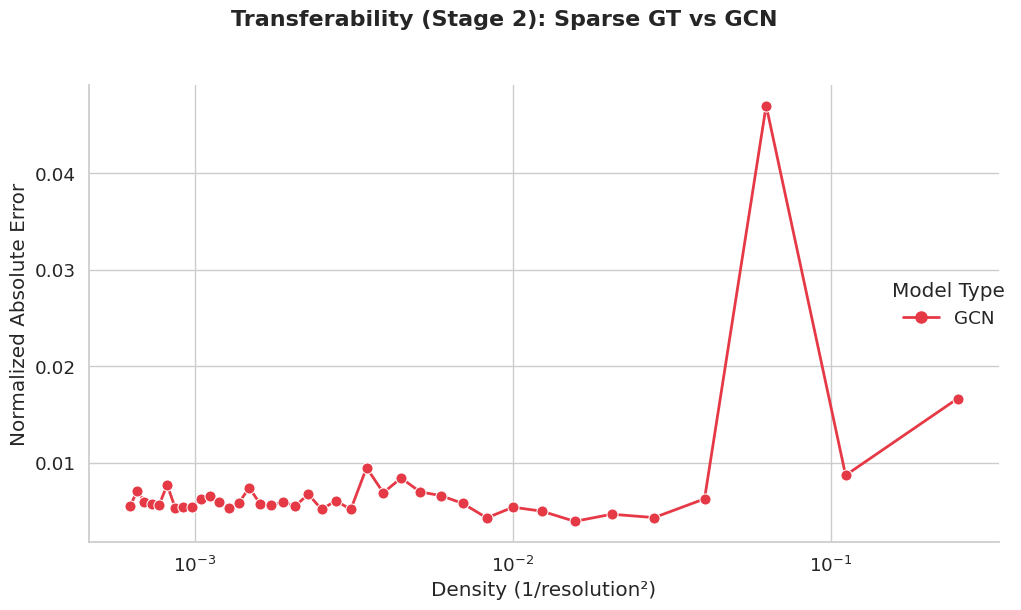

In [10]:
# Set plot style
sns.set_theme(style="whitegrid", font_scale=1.2)

# Filter to stage 2 only
df_stage2 = df[df['stage'] == 2]
print(f"Using {len(df_stage2)} stage 2 runs (filtered from {len(df)} total)")

# Create transferability plot
g = sns.relplot(
    data=df_stage2,
    x='density',
    y='normalized_abs_error',
    hue='model_type',
    kind='line',
    markers=True,
    style='model_type',
    height=6,
    aspect=1.5,
    errorbar=None,
    palette=['#E63946', '#457B9D'],  # Red for Sparse GT, Blue for GCN
    markersize=8,
    linewidth=2,
)

# Customize the plot
g.set_axis_labels("Density (1/resolution²)", "Normalized Absolute Error")
g.legend.set_title("Model Type")
g.fig.suptitle("Transferability (Stage 2): Sparse GT vs GCN", y=1.02, fontsize=16, fontweight='bold')

# Set x-axis to log scale
g.set(xscale='log')

plt.tight_layout()
plt.savefig('transferability_plot.png', dpi=150, bbox_inches='tight')
plt.show()


In [11]:
# # Summary statistics by model type and density
# summary_stats = df.groupby(['model_type', 'density'])['normalized_abs_error'].agg(
#     ['mean', 'std', 'count', 'min', 'max']
# ).round(4)

# print("Summary Statistics:")
# summary_stats


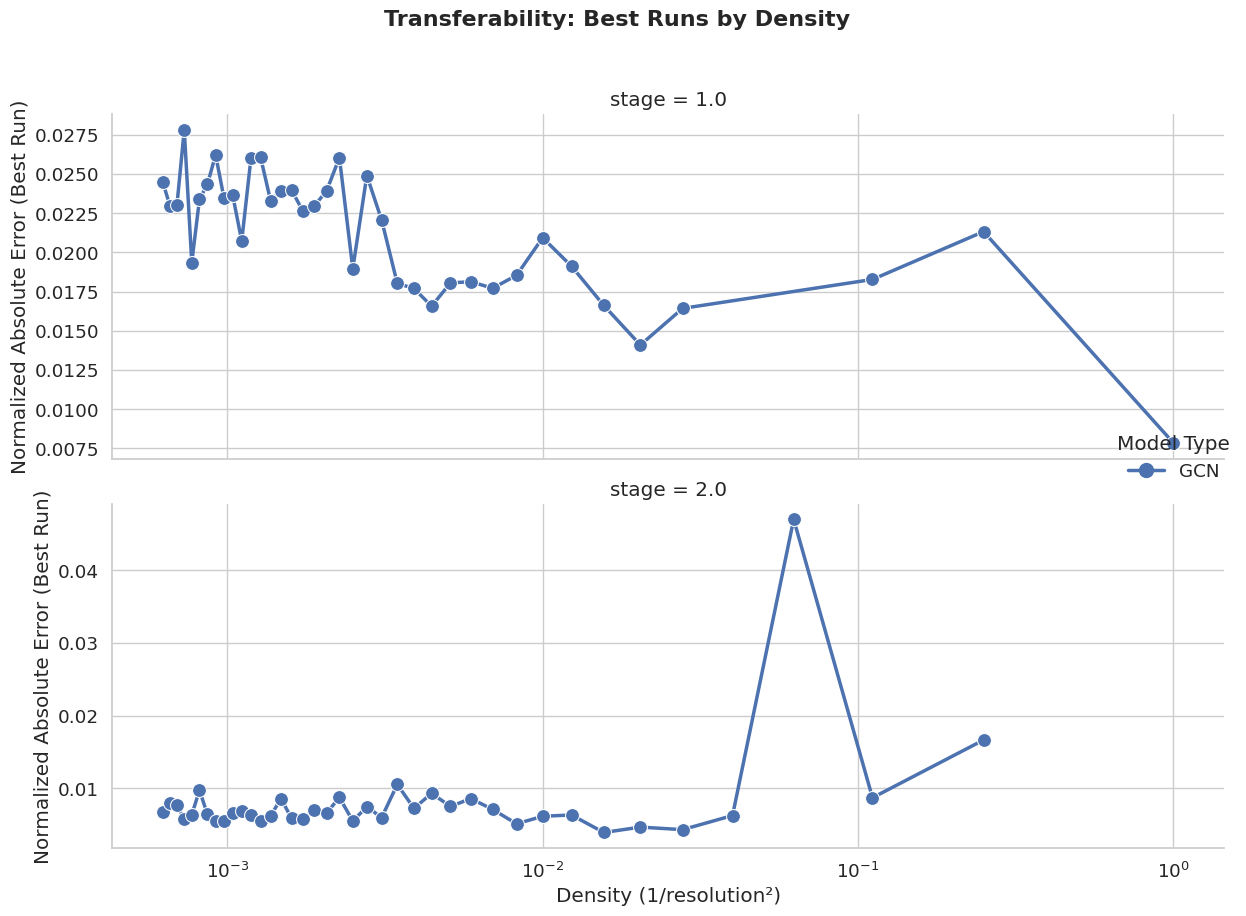

In [12]:
# Alternative view: Best performance per density per model
best_per_density = df.loc[df.groupby(['model_type', 'density', 'stage'])['normalized_abs_error'].idxmax()]

g2 = sns.relplot(
    data=best_per_density,
    x='density',
    y='normalized_abs_error',
    hue='model_type',
    kind='line',
    markers=True,
    style='model_type',
    row="stage",
    height=4.5,
    aspect=2.5,
    #palette=['#E63946', '#457B9D'],
    markersize=10,
    linewidth=2.5,
    facet_kws=dict(sharex=True, sharey=False),
)

g2.set_axis_labels("Density (1/resolution²)", "Normalized Absolute Error (Best Run)")
g2.legend.set_title("Model Type")
g2.fig.suptitle("Transferability: Best Runs by Density", y=1.02, fontsize=16, fontweight='bold')
g2.set(xscale='log')
plt.tight_layout()
plt.savefig('transferability_plot_best.png', dpi=150, bbox_inches='tight')
plt.show()


## Trimmed down, closer look at the small fractions

In [13]:
# # Export the combined dataframe for further analysis
# df.to_csv('wandb_runs_sparse_gt_gcn.csv', index=False)
# print("Data exported to wandb_runs_sparse_gt_gcn.csv")
